# SynCat demo
SynCat generates a random distribution of galaxy properties while preserving the correlations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import logging

logging.basicConfig(level=logging.INFO)

In [2]:
from pypelid.sky.catalogue import Catalogue
from pypelid.sky.catalogue_store import CatalogueStore
from pypelid.vm.syncat import SynCat
import plot_utils

/Users/ben/.virtualenvs/pypelid/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


# Initialize SynCat
The distribution will be fit with a Gaussian mixture model with 15 components.

The `hints_file` contains additional constraints about the parameter distributions. We can specify for example that galaxy position angle `PA` should be uncorrelated and drawn from a uniform distribution.  We can also specify parameter ranges e.g. redshift `z` should be between 0 and 6.

In [3]:
S = SynCat(verbose=1, ncomponents=15, overwrite=False, hints_file='in/syn_hints.txt')

Start model fitting.  The routine first subdivides the catalogue based upon discrete values.  It then calls the `scikit-learn` package to do the fitting. 

In [4]:
S.fit_catalogue()

INFO:pypelid.vm.syncat:reading out/syn.pickle
INFO:pypelid.vm.syn:Lodaed out/syn.pickle, got 206 fit results.


# Sample from the model
Now draw samples from the data model.

In [5]:
randoms = S.syn.sample(1851066)
labels = S.labels
print "Random catalogue has dimension:",randoms.shape

INFO:pypelid.vm.syn:drawing samples: n=1.85107e+06
INFO:pypelid.vm.syn:random sampling from uniform distribution 0.0 180.0 1851066


Random catalogue has dimension: (1851066, 11)


# Load the data catalogue for reference

In [6]:
with CatalogueStore('in/galaxies.pypelid.hdf5') as store:
    cat = Catalogue(store)
data = []
for name in S.labels:
    data.append(getattr(cat,name))
data = np.transpose(data)

In [7]:
print "Min and max values"
for i in range(randoms.shape[1]):
    print "%s rand (%s, %s) data (%s, %s)"%(S.syn.labels[i], randoms[:,i].min(),randoms[:,i].max(),data[:,i].min(),data[:,i].max())

Min and max values
ew_Ha rand (0.0, 512092.615867) data (0.0, 13225.7998047)
rdisk rand (0.0, 7.91401797921) data (0.0, 10.2159004211)
rbulge rand (0.0, 4.83119383012) data (0.0, 3.69390010834)
ell rand (0.0243684565657, 0.999999876717) data (0.0230000000447, 1.0)
ilbert_type rand (1.0, 18.0) data (1.0, 18.0)
bt rand (0.0, 1.0) data (0.0, 1.0)
ebv rand (0.0, 0.5) data (0.0, 0.5)
pa rand (5.32783664586e-05, 179.999721894) data (0.0, 180.0)
mag rand (14.0759696091, 30.2272780086) data (14.779999733, 31.4300003052)
z rand (0.00500365301407, 5.99959660066) data (0.00499999988824, 6.0)
flux_Ha rand (2.82168827044e-24, 2.29041431206e-12) data (3.06902012218e-23, 2.43500993024e-13)


# Plot joint distributions

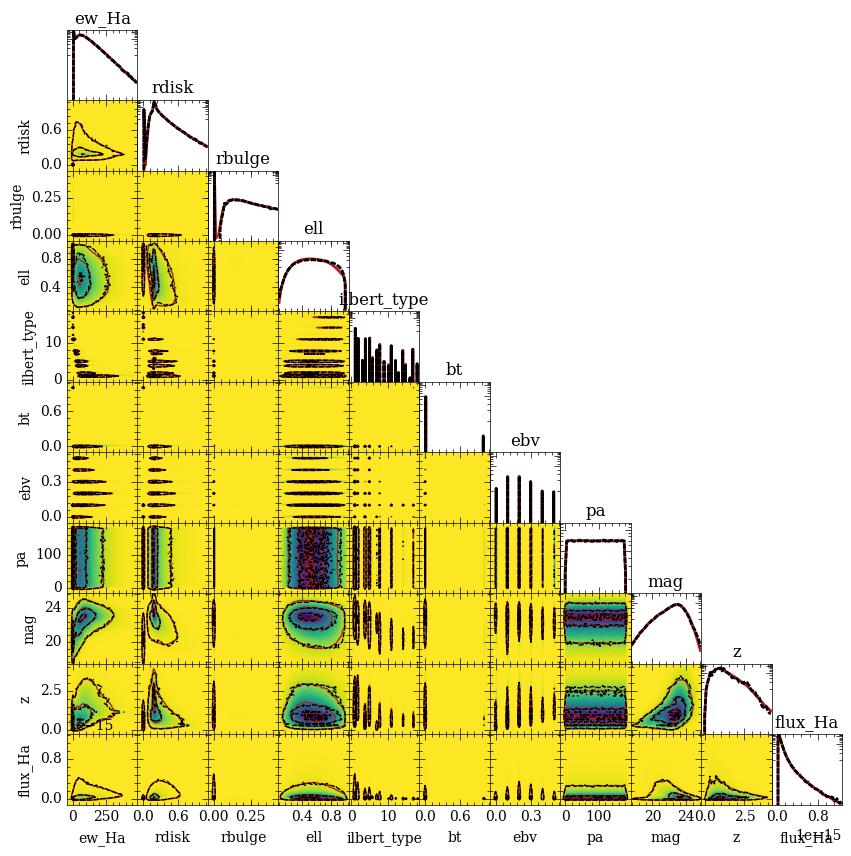

In [9]:
reload(plot_utils)
plot_utils.triangle_plot(data.T, randoms.T, names=S.labels)
plt.show()

# Plot marginalized distributions and KS Test
The big chunk of code below computes the marginalized distributions and statistics for the KS test.  The distributions are then plotted.

In [10]:
def cumulative_dist(x, bins):
    """ """
    h, e = np.histogram(x, bins)
    cum = np.cumsum(h)
    cum = cum * 1. / np.sum(h)
    return cum

data 1851066
rand 1851066
ew_Ha: D=0.00345223551898, c=3.32121025822, a=5.24944812394e-10
rdisk: D=0.00542730746459, c=5.22132083019, a=4.18207271688e-24
rbulge: D=0.000414881472514, c=0.3991351676, a=1.45430688079
ell: D=0.0489701609775, c=47.1115600576, a=0.0
ilbert_type: D=0.000373298412914, c=0.35913034077, a=1.54526895675
bt: D=0.000229597431966, c=0.220883349967, a=1.81406153243
ebv: D=8.26550755079e-05, c=0.0795180059883, a=1.97486680191
pa: D=0.00288752535026, c=2.7779329543, a=3.96465894261e-07
mag: D=0.00484543403424, c=4.66153167465, a=2.6711493283e-19
z: D=0.0141718339595, c=13.633959811, a=6.97416067483e-162
flux_Ha: D=0.00203227257971, c=1.95514022787, a=0.000956720334429


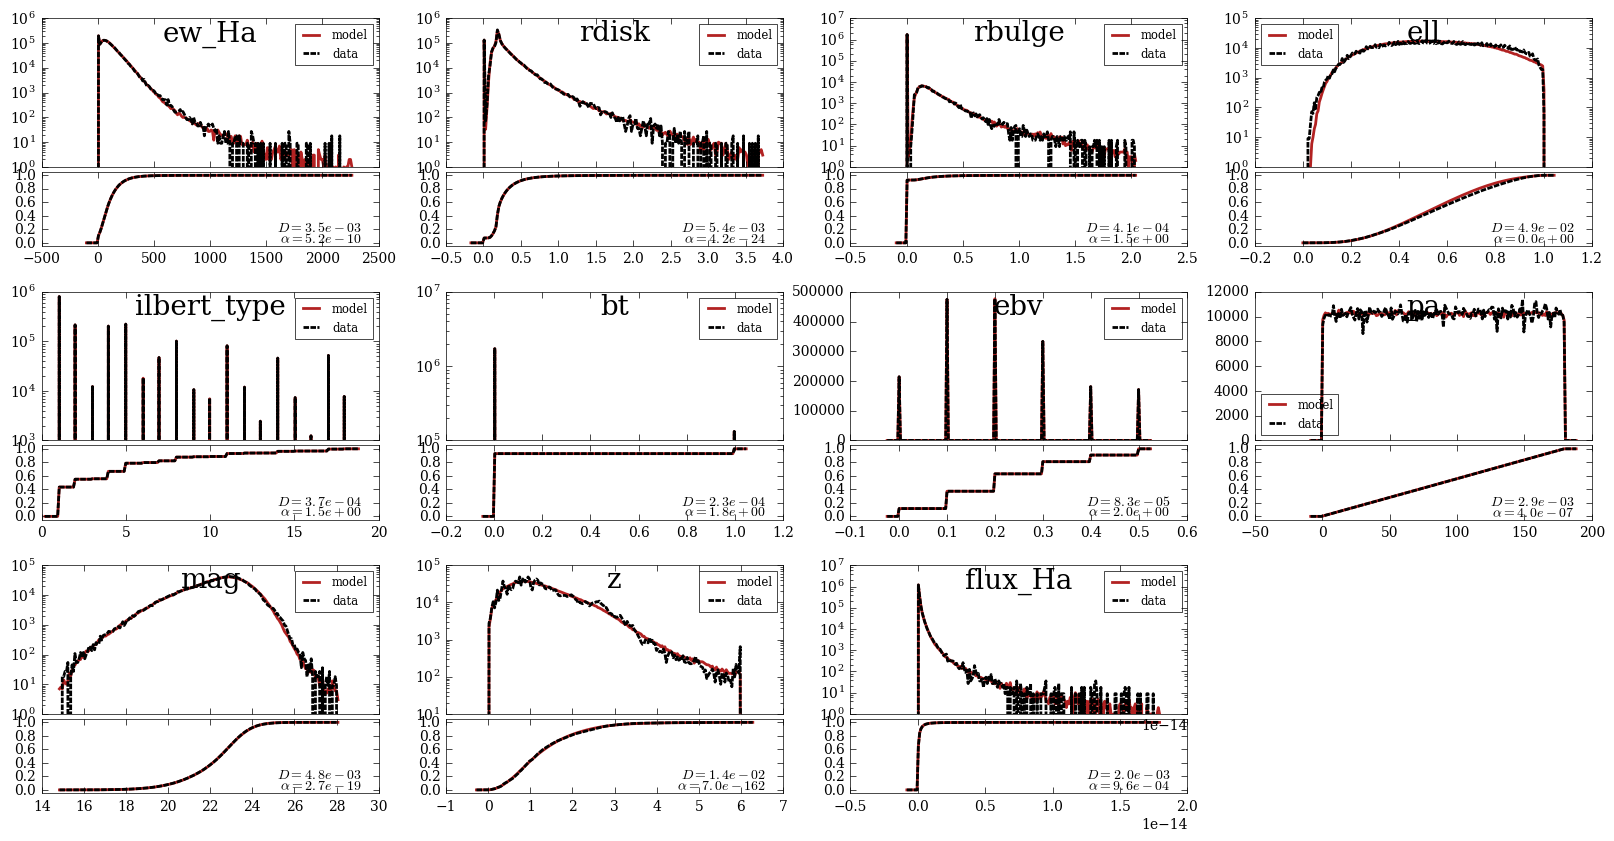

In [11]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

pval = [0.5, 0.90, 0.95, 0.99, 0.999]

n, dim = data.shape

print "data",n
print "rand",len(randoms)

fig = plt.figure(figsize=(20,10))
for i in range(dim):
    
    ax = fig.add_subplot(dim//4+1,4,i+1)
    
    divider = make_axes_locatable(ax)
    ax2 = divider.append_axes("bottom", size="50%", pad=0.05)
    fig.add_axes(ax2)

    low, high = np.percentile(data[:,i],[0.01,99.99])
    w = (high - low)/20.
    low -= w
    high += w

    bins = np.linspace(low,high,200)
    bc = (bins[1:]+bins[:-1])/2.
    
    h,e = np.histogram(data[:,i], bins)
    m,e = np.histogram(randoms[:,i], bins)
    
    hc = cumulative_dist(data[:,i], bins)
    mc = cumulative_dist(randoms[:,i], bins)
    
    D = np.abs(hc-mc).max()
    n1 = len(data[:,i])
    n2 = len(randoms[:,i])
    factor = np.sqrt((n1+n2)*1./(n1*n2))
    c = D / factor
    a = 2*np.exp(-2*c*c)
    
    print "{}: D={}, c={}, a={}".format(labels[i],D,c,a)
        
    ax.plot(bc, m, c='firebrick', lw=2, label="model")
    ax.plot(bc, h, c='k', lw=2, dashes=[4,1], label="data")
    
    ax2.plot(bc, mc, c='firebrick', lw=2, label="model")
    ax2.plot(bc, hc, c='k', lw=2, dashes=[4,1], label="data")

    high = h.max()
    low = h[h>0].min()
    if high/low > 10:
        ax.set_yscale('log')
    
    ax.text(0.5, 0.85, S.labels[i], fontsize=20, horizontalalignment='center', transform=ax.transAxes)
    ax2.text(0.95, 0.2, "$D=%3.1e$"%D, horizontalalignment='right', transform=ax2.transAxes)
    ax2.text(0.95, 0.05, "$\\alpha=%3.1e$"%a, horizontalalignment='right', transform=ax2.transAxes)
    ax.legend(loc='best')
    
    a,b = ax.get_xlim()
    ax.set_xlim(a, b)
    ax2.set_xlim(a, b)
    ax2.set_ylim(-0.05, 1.05)
    
    plt.setp(ax.get_xticklabels(), visible=False)

plt.show()